# SOLA vs. PLI Comparison: Two Approaches to Property Inference

## Overview

This notebook compares two related but distinct approaches for inferring localized properties from noisy observations:

1. **SOLA (Subtractive Optimally Localized Averages)**: Direct property inference without explicit model reconstruction
2. **PLI (Probabilistic Linear Inference)**: Full Bayesian inference via model posterior

Both methods solve the same fundamental problem but with different philosophical approaches:
- **SOLA**: Focuses directly on property estimation, bypassing full model reconstruction
- **PLI**: Uses Bayesian framework with explicit prior on model space

## Mathematical Framework

### Common Problem Setup
Given:
- Model space $\mathcal{M}$ (Hilbert space)
- Data space $\mathcal{D} \cong \mathbb{R}^{N_d}$ 
- Property space $\mathcal{P} \cong \mathbb{R}^{N_p}$
- Forward operator $G: \mathcal{M} \to \mathcal{D}$
- Target operator $\mathcal{T}: \mathcal{M} \to \mathcal{P}$
- Noisy data $\mathbf{\tilde{d}} = G(\bar{m}) + \bm{\eta}$

### SOLA Approach
Seeks optimal linear operator $\mathbf{X}: \mathcal{D} \to \mathcal{P}$ minimizing:
$$\|\mathcal{T} - \mathbf{X}G\|_{HS}^2 + \text{Tr}(\mathbf{X} \mathbf{C}_{\mathcal{D}} \mathbf{X}^*)$$

**Solution**: $\mathbf{X} = \mathcal{T} G^*(GG^* + \mathbf{C}_{\mathcal{D}})^{-1}$

**Property measure**: $\mu_{\mathcal{P}} = \mathbf{X}_* \mu_{\mathcal{D}}$

### PLI Approach  
Uses Bayesian framework with model prior $\mu_{\mathcal{M}}^0 = \mathcal{N}(m_0, C_0)$:

**Model posterior**: $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$ where:
- $C_{\mathcal{M}} = (G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1})^{-1}$
- $\tilde{m} = C_{\mathcal{M}}(G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1} m_0)$

**Property posterior**: $\mu_{\mathcal{P}} = \mathcal{T}_* \mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$

## Methodology

We will compare both methods on the same synthetic problem, analyzing:
- **Accuracy**: How well each method recovers true properties
- **Uncertainty quantification**: Quality of uncertainty estimates
- **Computational efficiency**: Speed and numerical stability
- **Interpretability**: Understanding of resolving vs. target kernels

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
import os

# PyGeoInf imports
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import LaplacianInverseOperator
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.bayesian import LinearBayesianInference

# Styling and output setup
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore', category=UserWarning)

# Create output directory
output_dir = 'sola_vs_pli_comparison'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("SOLA vs. PLI Comparison Study")
print("=" * 50)

/home/adrian/miniconda3/envs/inferences3/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


SOLA vs. PLI Comparison Study


## Experimental Setup

### Problem Configuration

We establish identical configurations for both methods to ensure fair comparison:
- **Domain**: $[0, 1]$
- **Model space**: $L^2$ with sine basis functions
- **Forward operator**: Normal modes with Gaussian sensitivity kernels
- **Target operator**: Localized bump functions for property extraction
- **Noise model**: Additive Gaussian with known covariance

In [ ]:
# Fixed experimental parameters
DOMAIN = IntervalDomain(0, 1)
N_BASIS = 50        # Number of basis functions for model space
N_DATA = 50         # Number of data points
N_PROPERTIES = 20   # Number of properties to infer
NOISE_LEVEL = 0.1   # Noise as fraction of signal
RANDOM_SEED = 42    # For reproducibility

# Create spaces
M = L2Space(N_BASIS, DOMAIN, basis_type='sine')  # Model space
D = EuclideanSpace(N_DATA)                       # Data space
P = EuclideanSpace(N_PROPERTIES)                 # Property space

# Target function parameters
width = 0.2
centers = np.linspace(DOMAIN.a + width / 2, DOMAIN.b - width / 2, N_PROPERTIES)

print(f"Model space: L^2 with {N_BASIS} sine basis functions")
print(f"Data points: {N_DATA}")
print(f"Properties: {N_PROPERTIES} localized targets")
print(f"Noise level: {NOISE_LEVEL*100}% of signal")

Model space: L^2 with 50 sine basis functions
Data points: 50
Properties: 20 localized targets
Noise level: 10.0% of signal


## Operators and True Model

### Forward and Target Operators

Both methods use identical forward and target operators for fair comparison.

Creating operators...
✓ Operators created


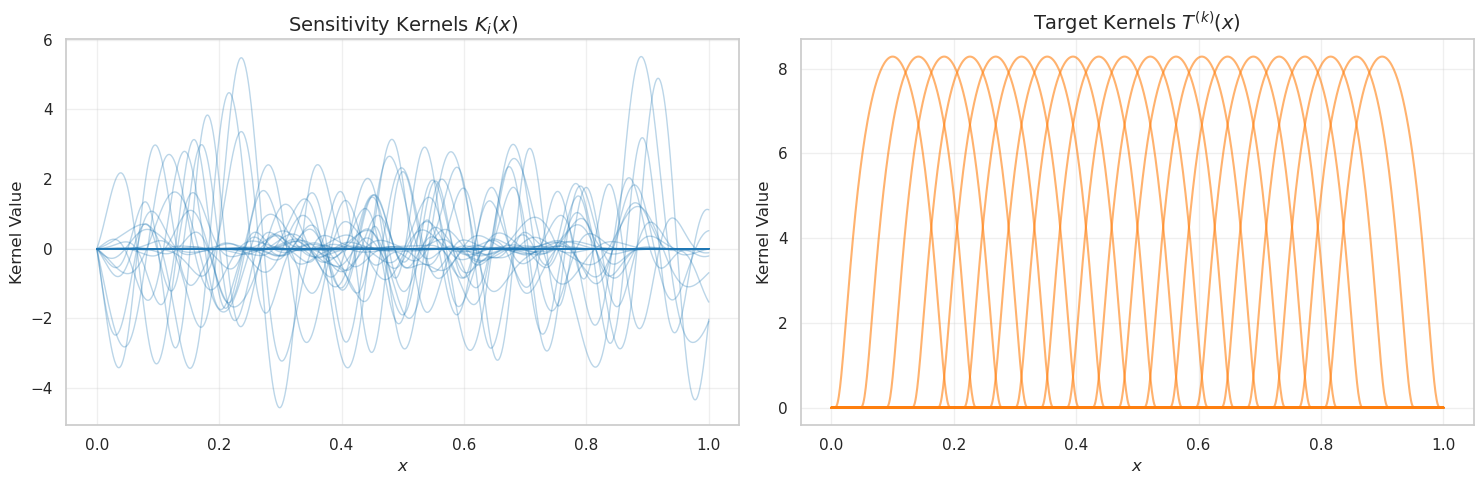

In [ ]:
# Create forward and target operators (identical for both methods)
print("Creating operators...")

# Forward operator: Normal modes with random Gaussian sensitivity kernels
normal_modes_provider = NormalModesProvider(
    M, gaussian_width_percent_range=(5, 10),
    freq_range=(5, 10), random_state=39
)
G = SOLAOperator(M, D, normal_modes_provider,
                integration_method='trapz', n_points=1000)

# Target operator: Bump functions for localized property extraction
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider,
                integration_method='trapz', n_points=1000)

print("✓ Operators created")

# Visualize sensitivity and target kernels
x_viz = np.linspace(DOMAIN.a, DOMAIN.b, 1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Sensitivity kernels
for i in range(N_DATA):
    ax1.plot(x_viz, G.function_provider.get_function_by_index(i).evaluate(x_viz),
             color='tab:blue', alpha=0.3, linewidth=1)
ax1.set_title('Sensitivity Kernels $K_i(x)$', fontsize=14)
ax1.set_xlabel('$x$', fontsize=12)
ax1.set_ylabel('Kernel Value', fontsize=12)
ax1.grid(True, alpha=0.3)

# Target kernels
for i in range(N_PROPERTIES):
    ax2.plot(x_viz, T.function_provider.get_function_by_index(i).evaluate(x_viz),
             color='tab:orange', alpha=0.6, linewidth=1.5)
ax2.set_title('Target Kernels $T^{(k)}(x)$', fontsize=14)
ax2.set_xlabel('$x$', fontsize=12)
ax2.set_ylabel('Kernel Value', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'operators.png'), dpi=300, bbox_inches='tight')
plt.show()

### Synthetic True Model

We create a challenging synthetic model with multiple frequency components to test both methods.

Generating synthetic data...
Signal-to-noise ratio: 10.0


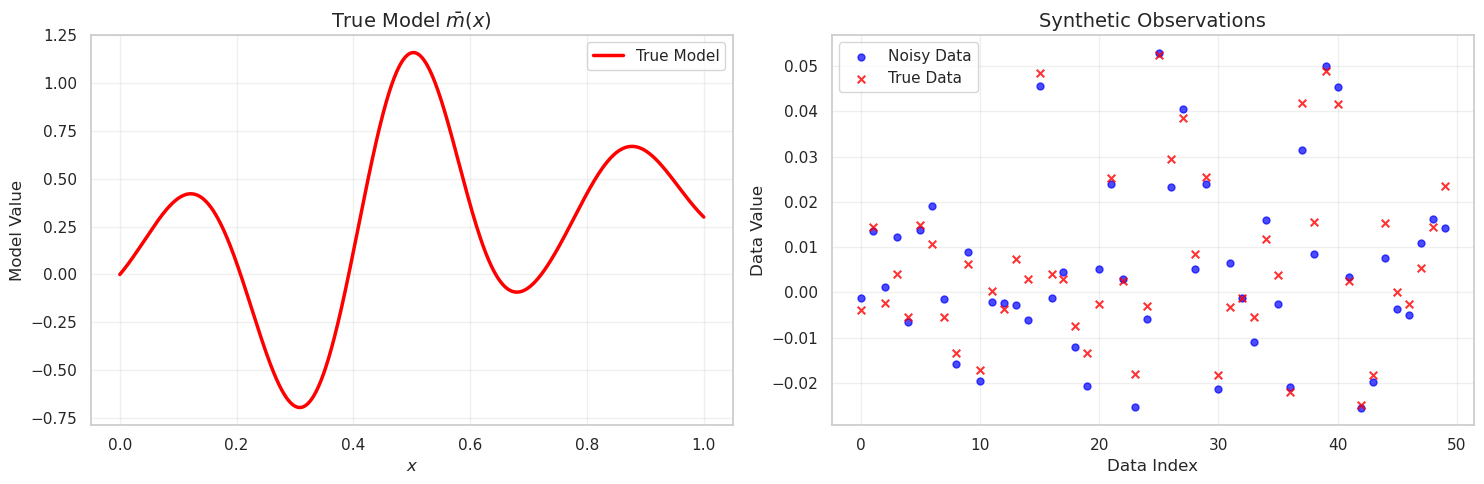

True properties computed at 20 locations


In [ ]:
# Create synthetic true model
def true_model_function(x):
    """Complex synthetic model with multiple features"""
    envelope = np.exp(-((x - DOMAIN.center)/0.4)**2)
    oscillation = np.sin(5 * np.pi * x)
    trend = 0.3 * x
    bump = 0.5 * np.exp(-((x - 0.7)/0.1)**2)
    return envelope * oscillation + trend + bump

m_bar = Function(M, evaluate_callable=true_model_function)

# Generate synthetic data
print("Generating synthetic data...")
np.random.seed(RANDOM_SEED)
d_clean = G(m_bar)
noise_std = NOISE_LEVEL * np.max(np.abs(d_clean))
noise = np.random.normal(0, noise_std, d_clean.shape)
d_noisy = d_clean + noise

print(f"Signal-to-noise ratio: {np.max(np.abs(d_clean))/noise_std:.1f}")

# Visualize true model and data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# True model
ax1.plot(x_viz, m_bar.evaluate(x_viz), 'r-', linewidth=2.5, label='True Model')
ax1.set_title('True Model $\\bar{m}(x)$', fontsize=14)
ax1.set_xlabel('$x$', fontsize=12)
ax1.set_ylabel('Model Value', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Data comparison
data_indices = np.arange(len(d_clean))
ax2.scatter(data_indices, d_noisy, alpha=0.7, s=25, color='blue', label='Noisy Data')
ax2.scatter(data_indices, d_clean, alpha=0.8, s=30, color='red', marker='x', label='True Data')
ax2.set_title('Synthetic Observations', fontsize=14)
ax2.set_xlabel('Data Index', fontsize=12)
ax2.set_ylabel('Data Value', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'true_model_and_data.png'), dpi=300, bbox_inches='tight')
plt.show()

# Compute true properties for comparison
p_true = T(m_bar)
print(f"True properties computed at {len(p_true)} locations")

## SOLA Method Implementation

### Direct Property Inference

SOLA focuses directly on property estimation without explicit model reconstruction.

In [5]:
print("="*60)
print("IMPLEMENTING SOLA METHOD")
print("="*60)

# Create data noise model for SOLA
noise_variance = noise_std**2
C_D_matrix = noise_variance * np.eye(N_DATA)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_noisy)

# Time SOLA computation
start_time = time.time()

print("Computing SOLA operator...")

# Step 1: Gram matrix Λ = GG*
print("  - Computing Gram matrix...")
Lambda = G @ G.adjoint

# Step 2: Regularized inverse (Λ + C_D)^{-1}
print("  - Computing regularized gram operator...")
cholesky_solver = CholeskySolver(galerkin=True)
W_inv = cholesky_solver(Lambda + gaussian_D.covariance)

# Step 3: Generalized inverse G† = G* W^{-1}
print("  - Computing generalized inverse...")
G_inv = G.adjoint @ W_inv

# Step 4: SOLA operator X = T G†
print("  - Computing SOLA operator...")
X_sola = T @ G_inv

sola_time = time.time() - start_time

# Property inference via push-forward
print("  - Computing property measure...")
property_measure_sola = gaussian_D.affine_mapping(operator=X_sola)
p_sola = property_measure_sola.expectation
cov_sola = property_measure_sola.covariance.matrix(dense=True)
std_sola = np.sqrt(np.diag(cov_sola))

print(f"✓ SOLA completed in {sola_time:.3f} seconds")
print(f"Property estimates computed with uncertainties")

# Optional: Model reconstruction for comparison
m_reconstructed_sola = G_inv(d_noisy)
reconstruction_error_sola = M.norm(m_reconstructed_sola - m_bar) / M.norm(m_bar)
print(f"Model reconstruction error: {reconstruction_error_sola:.4f}")

IMPLEMENTING SOLA METHOD
Computing SOLA operator...
  - Computing Gram matrix...
  - Computing regularized gram operator...
  - Computing generalized inverse...
  - Computing SOLA operator...
  - Computing property measure...
✓ SOLA completed in 1.182 seconds
Property estimates computed with uncertainties
Model reconstruction error: 1.1177


## PLI Method Implementation

### Bayesian Framework with Model Prior

PLI uses a full Bayesian framework with explicit prior on the model space.

In [6]:
print("="*60)
print("IMPLEMENTING PLI METHOD")
print("="*60)

# Set up model prior for PLI
print("Setting up Bayesian prior...")

# Define prior covariance: (-αΔ)^{-1} with Dirichlet BCs
bc_dirichlet = BoundaryConditions(bc_type='dirichlet', left=0, right=0)
alpha = 0.1  # Correlation length parameter
C_0 = LaplacianInverseOperator(M, bc_dirichlet, alpha=alpha)

# Prior mean
m_0 = Function(M, evaluate_callable=lambda x: x)

# Create Gaussian measure on model space
K = 200  # KL expansion terms
M.create_gaussian_measure(method='kl', kl_expansion=K, covariance=C_0, expectation=m_0)

print(f"Prior: (-{alpha}Δ)⁻¹ with linear mean")
print(f"Using {K} Karhunen-Loève terms")

# Time PLI computation
start_time = time.time()

print("Computing Bayesian posterior...")

# Set up forward problem and Bayesian inference
gaussian_D_error = GaussianMeasure.from_covariance_matrix(D, C_D_matrix)  # Zero mean for errors
forward_problem = LinearForwardProblem(G, gaussian_D_error)
bayesian_inference = LinearBayesianInference(forward_problem, M.gaussian_measure, T)

# Compute property posterior directly
print("  - Computing property posterior...")
solver = CholeskySolver()
property_posterior_pli = bayesian_inference.property_posterior_measure(d_noisy, solver)

pli_time = time.time() - start_time

# Extract results
p_pli = property_posterior_pli.expectation
cov_pli = property_posterior_pli.covariance.matrix(dense=True)
std_pli = np.sqrt(np.diag(cov_pli))

print(f"✓ PLI completed in {pli_time:.3f} seconds")

# Optional: Full model posterior for comparison
print("  - Computing model posterior...")
model_posterior_pli = bayesian_inference.model_posterior_measure(d_noisy, solver)
m_reconstructed_pli = model_posterior_pli.expectation
reconstruction_error_pli = M.norm(m_reconstructed_pli - m_bar) / M.norm(m_bar)
print(f"Model reconstruction error: {reconstruction_error_pli:.4f}")

IMPLEMENTING PLI METHOD
Setting up Bayesian prior...
DOLFINx found but has compatibility issues, using native solver
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs
Prior: (-0.1Δ)⁻¹ with linear mean
Using 200 Karhunen-Loève terms
Computing Bayesian posterior...
  - Computing property posterior...
✓ PLI completed in 2.408 seconds
  - Computing model posterior...
Model reconstruction error: 0.4009


## Comparative Analysis

### Property Inference Accuracy

We compare the accuracy of both methods in recovering the true properties.

ACCURACY COMPARISON
SOLA - Mean Absolute Error: 0.189709
PLI  - Mean Absolute Error: 0.164527
SOLA - RMS Error: 0.213294
PLI  - RMS Error: 0.179896
Better accuracy: PLI (MAE)
Improvement ratio: 1.15x


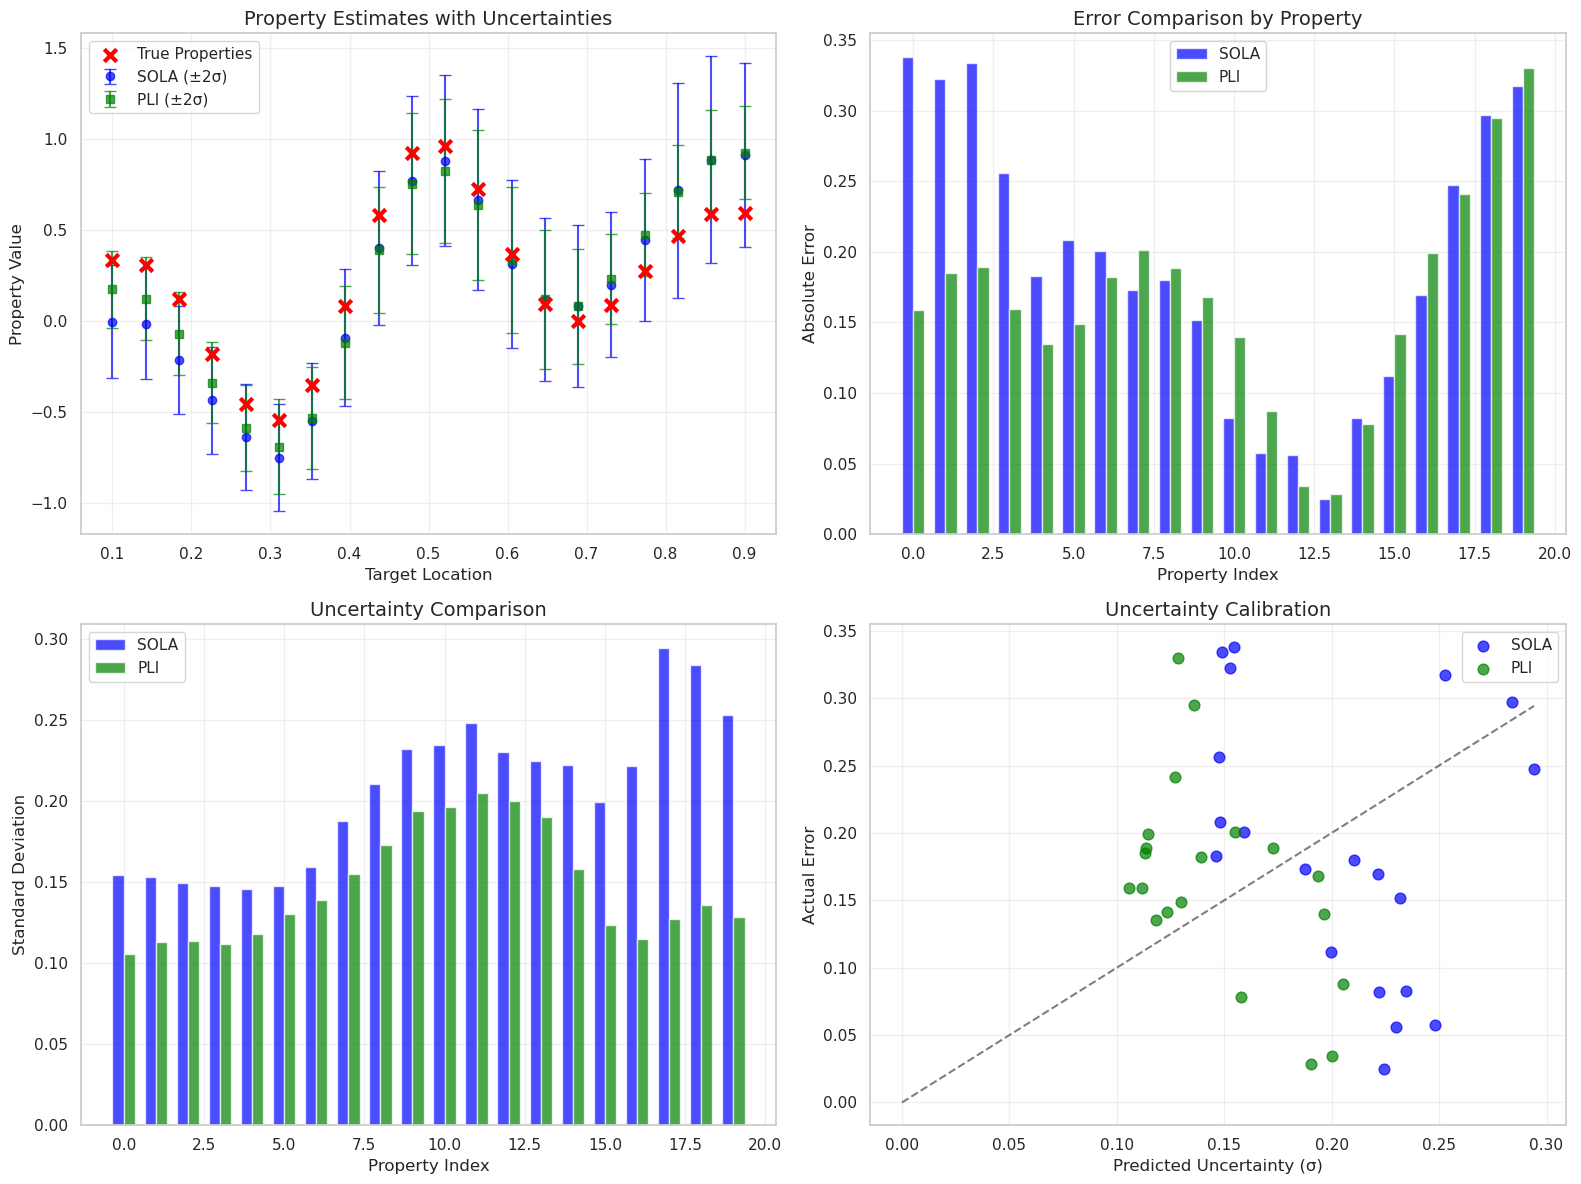

In [ ]:
# Compute error metrics
errors_sola = np.abs(p_sola - p_true)
errors_pli = np.abs(p_pli - p_true)

rmse_sola = np.sqrt(np.mean(errors_sola**2))
rmse_pli = np.sqrt(np.mean(errors_pli**2))

mae_sola = np.mean(errors_sola)
mae_pli = np.mean(errors_pli)

print("="*60)
print("ACCURACY COMPARISON")
print("="*60)
print(f"SOLA - Mean Absolute Error: {mae_sola:.6f}")
print(f"PLI  - Mean Absolute Error: {mae_pli:.6f}")
print(f"SOLA - RMS Error: {rmse_sola:.6f}")
print(f"PLI  - RMS Error: {rmse_pli:.6f}")
print(f"Better accuracy: {'SOLA' if mae_sola < mae_pli else 'PLI'} (MAE)")
print(f"Improvement ratio: {max(mae_sola, mae_pli)/min(mae_sola, mae_pli):.2f}x")
print("="*60)

# Visualization of property inference results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Property estimates comparison
ax = axes[0, 0]
ax.errorbar(centers, p_sola, yerr=2*std_sola, fmt='o', alpha=0.7,
           capsize=4, label='SOLA (±2σ)', color='blue', markersize=6)
ax.errorbar(centers, p_pli, yerr=2*std_pli, fmt='s', alpha=0.7,
           capsize=4, label='PLI (±2σ)', color='green', markersize=6)
ax.scatter(centers, p_true, color='red', marker='x', s=80,
          linewidths=3, label='True Properties', zorder=10)
ax.set_xlabel('Target Location', fontsize=12)
ax.set_ylabel('Property Value', fontsize=12)
ax.set_title('Property Estimates with Uncertainties', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Error comparison
ax = axes[0, 1]
x_positions = np.arange(len(centers))
width = 0.35
ax.bar(x_positions - width/2, errors_sola, width, label='SOLA', alpha=0.7, color='blue')
ax.bar(x_positions + width/2, errors_pli, width, label='PLI', alpha=0.7, color='green')
ax.set_xlabel('Property Index', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('Error Comparison by Property', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Uncertainty comparison
ax = axes[1, 0]
ax.bar(x_positions - width/2, std_sola, width, label='SOLA', alpha=0.7, color='blue')
ax.bar(x_positions + width/2, std_pli, width, label='PLI', alpha=0.7, color='green')
ax.set_xlabel('Property Index', fontsize=12)
ax.set_ylabel('Standard Deviation', fontsize=12)
ax.set_title('Uncertainty Comparison', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Error vs uncertainty scatter
ax = axes[1, 1]
ax.scatter(std_sola, errors_sola, alpha=0.7, s=60, color='blue', label='SOLA')
ax.scatter(std_pli, errors_pli, alpha=0.7, s=60, color='green', label='PLI')
ax.plot([0, max(np.max(std_sola), np.max(std_pli))],
        [0, max(np.max(std_sola), np.max(std_pli))], 'k--', alpha=0.5)
ax.set_xlabel('Predicted Uncertainty (σ)', fontsize=12)
ax.set_ylabel('Actual Error', fontsize=12)
ax.set_title('Uncertainty Calibration', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'property_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

### Model Reconstruction Comparison

Although property inference is the primary goal, we can also compare the model reconstructions.

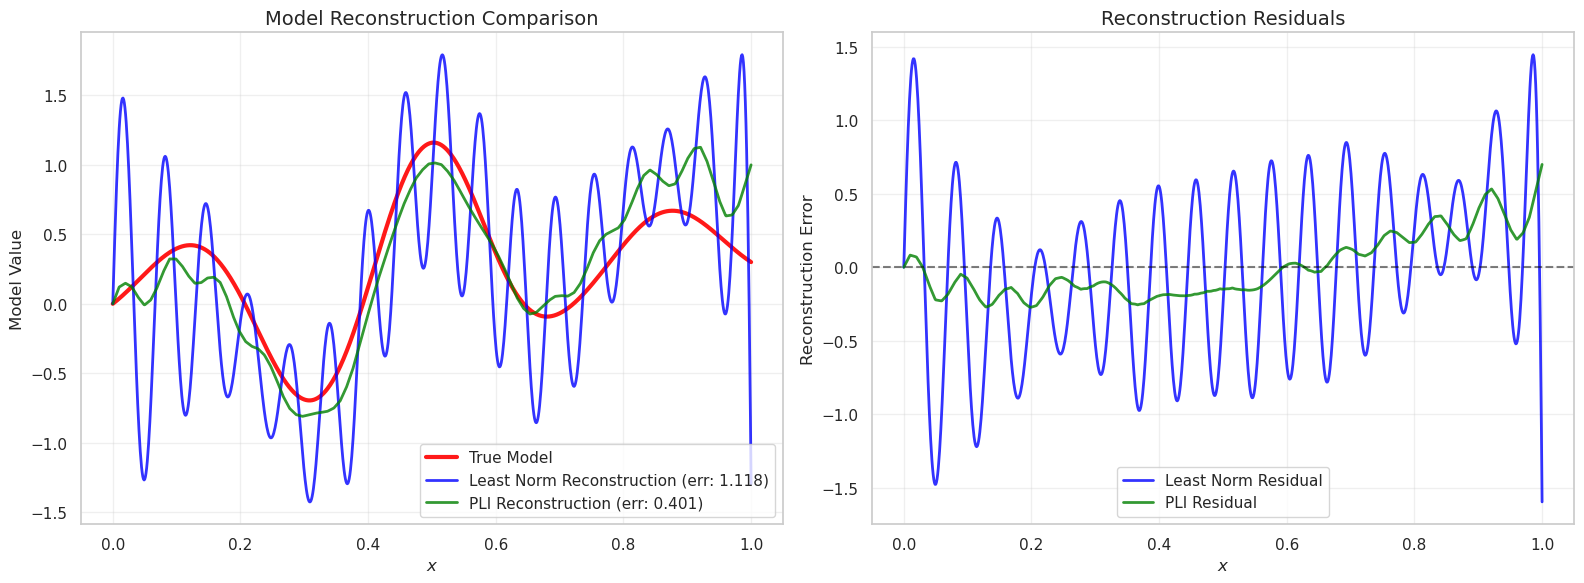

Model reconstruction errors:
  SOLA: 1.117653
  PLI:  0.400939
  Better reconstruction: PLI


In [12]:
# Model reconstruction comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Reconstructed models
ax1.plot(x_viz, m_bar.evaluate(x_viz), 'r-', linewidth=3, label='True Model', alpha=0.9)
ax1.plot(x_viz, m_reconstructed_sola.evaluate(x_viz), 'b-', linewidth=2,
         label=f'Least Norm Reconstruction (err: {reconstruction_error_sola:.3f})', alpha=0.8)
ax1.plot(x_viz, m_reconstructed_pli.evaluate(x_viz), 'g-', linewidth=2,
         label=f'PLI Reconstruction (err: {reconstruction_error_pli:.3f})', alpha=0.8)
ax1.set_xlabel('$x$', fontsize=12)
ax1.set_ylabel('Model Value', fontsize=12)
ax1.set_title('Model Reconstruction Comparison', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Reconstruction errors
residual_sola = m_reconstructed_sola.evaluate(x_viz) - m_bar.evaluate(x_viz)
residual_pli = m_reconstructed_pli.evaluate(x_viz) - m_bar.evaluate(x_viz)

ax2.plot(x_viz, residual_sola, 'b-', linewidth=2, label='Least Norm Residual', alpha=0.8)
ax2.plot(x_viz, residual_pli, 'g-', linewidth=2, label='PLI Residual', alpha=0.8)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('$x$', fontsize=12)
ax2.set_ylabel('Reconstruction Error', fontsize=12)
ax2.set_title('Reconstruction Residuals', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'model_reconstruction_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Model reconstruction errors:")
print(f"  SOLA: {reconstruction_error_sola:.6f}")
print(f"  PLI:  {reconstruction_error_pli:.6f}")
print(f"  Better reconstruction: {'SOLA' if reconstruction_error_sola < reconstruction_error_pli else 'PLI'}")

### Computational Performance

Compare the computational efficiency and timing breakdown.

COMPUTATIONAL PERFORMANCE
SOLA total time: 1.182 seconds
PLI total time:  2.408 seconds
Speedup: 2.04x for SOLA


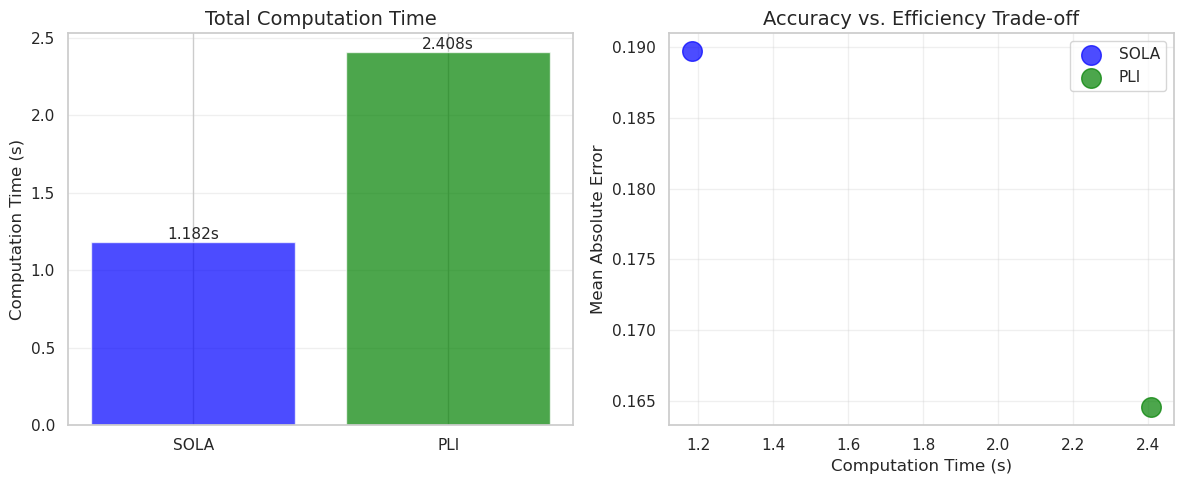

In [9]:
# Computational performance comparison
print("="*60)
print("COMPUTATIONAL PERFORMANCE")
print("="*60)
print(f"SOLA total time: {sola_time:.3f} seconds")
print(f"PLI total time:  {pli_time:.3f} seconds")
print(f"Speedup: {max(sola_time, pli_time)/min(sola_time, pli_time):.2f}x for {'SOLA' if sola_time < pli_time else 'PLI'}")
print("="*60)

# Performance visualization
methods = ['SOLA', 'PLI']
times = [sola_time, pli_time]
colors = ['blue', 'green']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Timing comparison
bars = ax1.bar(methods, times, color=colors, alpha=0.7)
ax1.set_ylabel('Computation Time (s)', fontsize=12)
ax1.set_title('Total Computation Time', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{time_val:.3f}s', ha='center', va='bottom', fontsize=11)

# Accuracy vs speed trade-off
ax2.scatter([sola_time], [mae_sola], s=200, color='blue', alpha=0.7, label='SOLA')
ax2.scatter([pli_time], [mae_pli], s=200, color='green', alpha=0.7, label='PLI')
ax2.set_xlabel('Computation Time (s)', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Accuracy vs. Efficiency Trade-off', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

### Uncertainty Quantification Analysis

Analyze the quality of uncertainty estimates from both methods.

UNCERTAINTY QUANTIFICATION
Coverage (fraction of errors within predicted uncertainty):
SOLA - 1σ coverage: 0.55 (ideal: 0.68)
SOLA - 2σ coverage: 0.85 (ideal: 0.95)
PLI  - 1σ coverage: 0.30 (ideal: 0.68)
PLI  - 2σ coverage: 0.90 (ideal: 0.95)

Average uncertainty:
SOLA: 0.204855
PLI:  0.146638


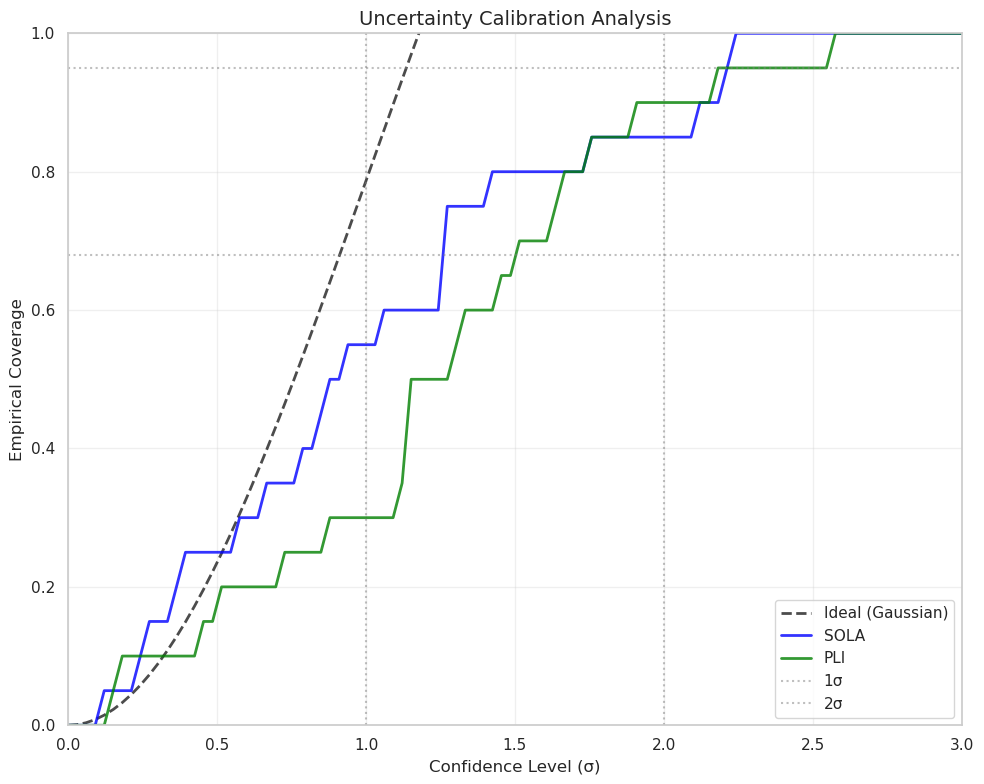

In [10]:
# Uncertainty quantification analysis
coverage_sola_1sigma = np.sum(errors_sola <= std_sola) / len(errors_sola)
coverage_sola_2sigma = np.sum(errors_sola <= 2*std_sola) / len(errors_sola)

coverage_pli_1sigma = np.sum(errors_pli <= std_pli) / len(errors_pli)
coverage_pli_2sigma = np.sum(errors_pli <= 2*std_pli) / len(errors_pli)

print("="*60)
print("UNCERTAINTY QUANTIFICATION")
print("="*60)
print("Coverage (fraction of errors within predicted uncertainty):")
print(f"SOLA - 1σ coverage: {coverage_sola_1sigma:.2f} (ideal: 0.68)")
print(f"SOLA - 2σ coverage: {coverage_sola_2sigma:.2f} (ideal: 0.95)")
print(f"PLI  - 1σ coverage: {coverage_pli_1sigma:.2f} (ideal: 0.68)")
print(f"PLI  - 2σ coverage: {coverage_pli_2sigma:.2f} (ideal: 0.95)")
print()
print(f"Average uncertainty:")
print(f"SOLA: {np.mean(std_sola):.6f}")
print(f"PLI:  {np.mean(std_pli):.6f}")
print("="*60)

# Uncertainty calibration plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create calibration data
confidence_levels = np.linspace(0, 3, 100)
empirical_coverage_sola = []
empirical_coverage_pli = []

for level in confidence_levels:
    empirical_coverage_sola.append(np.sum(errors_sola <= level * std_sola) / len(errors_sola))
    empirical_coverage_pli.append(np.sum(errors_pli <= level * std_pli) / len(errors_pli))

# Theoretical coverage for Gaussian
theoretical_coverage = 2 * (1 - np.exp(-0.5 * confidence_levels**2)) * (confidence_levels > 0)

ax.plot(confidence_levels, theoretical_coverage, 'k--', linewidth=2,
        label='Ideal (Gaussian)', alpha=0.7)
ax.plot(confidence_levels, empirical_coverage_sola, 'b-', linewidth=2,
        label='SOLA', alpha=0.8)
ax.plot(confidence_levels, empirical_coverage_pli, 'g-', linewidth=2,
        label='PLI', alpha=0.8)

# Mark 1σ and 2σ points
ax.axvline(x=1, color='gray', linestyle=':', alpha=0.5, label='1σ')
ax.axvline(x=2, color='gray', linestyle=':', alpha=0.5, label='2σ')
ax.axhline(y=0.68, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=0.95, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Confidence Level (σ)', fontsize=12)
ax.set_ylabel('Empirical Coverage', fontsize=12)
ax.set_title('Uncertainty Calibration Analysis', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'uncertainty_calibration.png'), dpi=300, bbox_inches='tight')
plt.show()